In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import glob
import h5py

import sys
sys.path.append('../../../../src')
from utils import smooth_curve
from viz import show_images
from PlumeDataset import plume_dataset
from AutoAlign import align_plumes
from Velocity import VelocityCalculator
from PlumeMetrics import PlumeMetrics
from HorizontalLineProfileAnalyzer import HorizontalLineProfileAnalyzer
from AutoAlign import visualize_corners
from analyze_function import analyze_function

## add growth condition to csv

In [33]:
def pivot_column(df, value_col):
    pivoted = df.pivot_table(
        values=value_col,
        index=['Growth', 'plume_index', 'time_index', 'Pressure (mTorr)', 
               'Temperature (C)', 'Fluence (J per cm2)', 'Repetation rate (Hz)'],
        columns='Threshold',
        aggfunc='first'
    )
    pivoted.columns = [f'{value_col}({col})' for col in pivoted.columns]
    return pivoted

In [34]:
df_condition = pd.read_excel('../../../../datasets/Sample log.xlsx', sheet_name='SRO')
df_condition = df_condition.loc[16:34, ['Growth', 'Pressure (mTorr)', 'Temperature (C)', 'Fluence (J/cm2)', 'Repetation rate (Hz)']]
df_condition.replace('2 to 1.73', (2+1.73)/2, inplace=True)
df_condition.replace('650 (heater O)', 650, inplace=True)
df_condition.replace('600 (heater O)', 600, inplace=True)
df_condition.replace('700 (heater O)', 700, inplace=True)
df_condition.replace('800 (heater O)', 800, inplace=True)
df_condition['Growth'] = df_condition['Growth'].str.replace(r'LYW_YCG', 'YG', regex=True)
df_condition = df_condition.rename(columns={'Fluence (J/cm2)': 'Fluence (J per cm2)'})

# print('Pressure (mTorr):', df_condition['Pressure (mTorr)'].unique())
# print('Temperature (C):', df_condition['Temperature (C)'].unique())
# print('Fluence (J/cm2):', df_condition['Fluence (J/cm2)'].unique())
# print('Repetation rate (Hz):', df_condition['Repetation rate (Hz)'].unique())
df_condition

,Growth,Pressure (mTorr),Temperature (C),Fluence (J per cm2),Repetation rate (Hz)
16,YG045,75.0,700,1.692857,10.0
17,YG046,75.0,700,1.865000,10.0
18,YG047,75.0,700,2.050000,10.0
19,YG048,75.0,700,2.050000,5.0
20,YG049,75.0,700,2.050000,2.0
21,YG050,100.0,700,2.050000,5.0
22,YG051,75.0,700,2.050000,5.0
23,YG052,75.0,650,2.050000,5.0
24,YG053,75.0,700,1.600000,5.0
25,YG054,75.0,800,1.600000,5.0


In [35]:
df_condition['Growth'].unique()

array(['YG045', 'YG046', 'YG047', 'YG048', 'YG049', 'YG050', 'YG051',
       'YG052', 'YG053', 'YG054', 'YG055', 'YG056', 'YG057', 'YG058',
       'YG059', 'YG060', 'YG061', 'YG062', 'YG063'], dtype=object)

In [37]:
for key in df_condition['Growth'].unique():
    file = glob.glob(f'../../../../datasets/SRO_plume_metrics/{key}*.csv')[0]
    df = pd.read_csv(file)
    df['Threshold'] = df['Threshold'].astype(str)
    
    print(key)
    merged_df = pd.merge(df, df_condition, on='Growth', how='left')
    merged_df.to_csv(f'../../../../datasets/SRO_plume_metrics/{key}_metrics_with_conditions.csv')
    
    # add the efficiency version: seperate area, distance, 
    #     and velocity based on the threshold and remove threshold column to reduce the overall length of dataframe
    area_pivoted = pivot_column(merged_df, 'Area')
    distance_pivoted = pivot_column(merged_df, 'Distance')
    velocity_pivoted = pivot_column(merged_df, 'Velocity')

    merged_df_eff = pd.concat([area_pivoted, distance_pivoted, velocity_pivoted], axis=1)
    merged_df_eff.reset_index(inplace=True)
    merged_df_eff.to_csv(f'../../../../datasets/SRO_plume_metrics/{key}_metrics_with_conditions-efficiency.csv')

YG045
YG046
YG047
YG048
YG049
YG050
YG051
YG052
YG053
YG054
YG055
YG056
YG057
YG058
YG059
YG060
YG061
YG062
YG063


In [38]:
merged_df_eff

,Growth,plume_index,time_index,Pressure (mTorr),Temperature (C),Fluence (J per cm2),Repetation rate (Hz),Area(200),Area(5),Area(flexible),Distance(200),Distance(5),Distance(flexible),Velocity(200),Velocity(5),Velocity(flexible)
0,YG063,0,0,100.0,700,1.6,5.0,0.0,0.0,0.0,0,0,18,0.0,0.0,0.0
1,YG063,0,1,100.0,700,1.6,5.0,0.0,0.0,0.0,0,0,18,0.0,0.0,0.0
2,YG063,0,2,100.0,700,1.6,5.0,852.0,17675.0,1034.0,46,156,36,92000000.0,312000000.0,36000000.0
3,YG063,0,3,100.0,700,1.6,5.0,3190.0,15483.0,3803.0,93,189,85,94000000.0,66000000.0,98000000.0
4,YG063,0,4,100.0,700,1.6,5.0,8585.0,18156.0,9804.0,136,189,132,86000000.0,0.0,94000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48635,YG063,379,123,100.0,700,1.6,5.0,0.0,0.0,0.0,0,0,18,0.0,0.0,0.0
48636,YG063,379,124,100.0,700,1.6,5.0,0.0,0.0,0.0,0,0,18,0.0,0.0,0.0
48637,YG063,379,125,100.0,700,1.6,5.0,0.0,0.0,0.0,0,0,18,0.0,0.0,0.0
48638,YG063,379,126,100.0,700,1.6,5.0,0.0,0.0,0.0,0,0,18,0.0,0.0,0.0


In [27]:
# exam the size of the files    
    
for key in df_condition['Growth'].unique():
    df = pd.read_csv(f'../../../../datasets/SRO_plume_metrics/{key}_metrics_with_conditions.csv', index_col=0)
    df_eff = pd.read_csv(f'../../../../datasets/SRO_plume_metrics/{key}_metrics_with_conditions-efficiency.csv', index_col=0)
    print(key, df.shape, df_eff.shape)
    for col in df.columns:
        print('--', col, df[col].dtype)
    for col in df_eff.columns:
        print('----', col, df_eff[col].dtype)

YG045 (59904, 11) (19968, 16)
-- plume_index int64
-- time_index int64
-- Distance int64
-- Velocity float64
-- Area float64
-- Threshold object
-- Growth object
-- Pressure (mTorr) float64
-- Temperature (C) int64
-- Fluence (J/cm2) float64
-- Repetation rate (Hz) float64
---- Growth object
---- plume_index int64
---- time_index int64
---- Pressure (mTorr) float64
---- Temperature (C) int64
---- Fluence (J/cm2) float64
---- Repetation rate (Hz) float64
---- Area(200) float64
---- Area(5) float64
---- Area(flexible) float64
---- Distance(200) int64
---- Distance(5) int64
---- Distance(flexible) int64
---- Velocity(200) float64
---- Velocity(5) float64
---- Velocity(flexible) float64
YG046 (48000, 11) (16000, 16)
-- plume_index int64
-- time_index int64
-- Distance int64
-- Velocity float64
-- Area float64
-- Threshold object
-- Growth object
-- Pressure (mTorr) float64
-- Temperature (C) int64
-- Fluence (J/cm2) float64
-- Repetation rate (Hz) float64
---- Growth object
---- plume_inde

C:\Users\yig319\AppData\Local\Temp\ipykernel_41128\2809241814.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../../../../datasets/SRO_plume_metrics/{key}_metrics_with_conditions.csv', index_col=0)


YG049 (176256, 11) (58752, 16)
-- plume_index int64
-- time_index int64
-- Distance int64
-- Velocity float64
-- Area float64
-- Threshold object
-- Growth object
-- Pressure (mTorr) float64
-- Temperature (C) int64
-- Fluence (J/cm2) float64
-- Repetation rate (Hz) float64
---- Growth object
---- plume_index int64
---- time_index int64
---- Pressure (mTorr) float64
---- Temperature (C) int64
---- Fluence (J/cm2) float64
---- Repetation rate (Hz) float64
---- Area(200) float64
---- Area(5) float64
---- Area(flexible) float64
---- Distance(200) int64
---- Distance(5) int64
---- Distance(flexible) int64
---- Velocity(200) float64
---- Velocity(5) float64
---- Velocity(flexible) float64
YG050 (72576, 11) (24192, 16)
-- plume_index int64
-- time_index int64
-- Distance int64
-- Velocity float64
-- Area float64
-- Threshold object
-- Growth object
-- Pressure (mTorr) float64
-- Temperature (C) int64
-- Fluence (J/cm2) float64
-- Repetation rate (Hz) float64
---- Growth object
---- plume_ind

C:\Users\yig319\AppData\Local\Temp\ipykernel_41128\2809241814.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../../../../datasets/SRO_plume_metrics/{key}_metrics_with_conditions.csv', index_col=0)
C:\Users\yig319\AppData\Local\Temp\ipykernel_41128\2809241814.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../../../../datasets/SRO_plume_metrics/{key}_metrics_with_conditions.csv', index_col=0)


YG058 (144384, 11) (48128, 16)
-- plume_index int64
-- time_index int64
-- Distance int64
-- Velocity float64
-- Area float64
-- Threshold object
-- Growth object
-- Pressure (mTorr) float64
-- Temperature (C) int64
-- Fluence (J/cm2) float64
-- Repetation rate (Hz) float64
---- Growth object
---- plume_index int64
---- time_index int64
---- Pressure (mTorr) float64
---- Temperature (C) int64
---- Fluence (J/cm2) float64
---- Repetation rate (Hz) float64
---- Area(200) float64
---- Area(5) float64
---- Area(flexible) float64
---- Distance(200) int64
---- Distance(5) int64
---- Distance(flexible) int64
---- Velocity(200) float64
---- Velocity(5) float64
---- Velocity(flexible) float64
YG059 (120576, 11) (40192, 16)
-- plume_index int64
-- time_index int64
-- Distance int64
-- Velocity float64
-- Area float64
-- Threshold object
-- Growth object
-- Pressure (mTorr) float64
-- Temperature (C) int64
-- Fluence (J/cm2) float64
-- Repetation rate (Hz) float64
---- Growth object
---- plume_in

C:\Users\yig319\AppData\Local\Temp\ipykernel_41128\2809241814.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../../../../datasets/SRO_plume_metrics/{key}_metrics_with_conditions.csv', index_col=0)
C:\Users\yig319\AppData\Local\Temp\ipykernel_41128\2809241814.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../../../../datasets/SRO_plume_metrics/{key}_metrics_with_conditions.csv', index_col=0)


YG060 (117504, 11) (39168, 16)
-- plume_index int64
-- time_index int64
-- Distance int64
-- Velocity float64
-- Area float64
-- Threshold object
-- Growth object
-- Pressure (mTorr) float64
-- Temperature (C) int64
-- Fluence (J/cm2) float64
-- Repetation rate (Hz) float64
---- Growth object
---- plume_index int64
---- time_index int64
---- Pressure (mTorr) float64
---- Temperature (C) int64
---- Fluence (J/cm2) float64
---- Repetation rate (Hz) float64
---- Area(200) float64
---- Area(5) float64
---- Area(flexible) float64
---- Distance(200) int64
---- Distance(5) int64
---- Distance(flexible) int64
---- Velocity(200) float64
---- Velocity(5) float64
---- Velocity(flexible) float64
YG061 (144768, 11) (48256, 16)
-- plume_index int64
-- time_index int64
-- Distance int64
-- Velocity float64
-- Area float64
-- Threshold object
-- Growth object
-- Pressure (mTorr) float64
-- Temperature (C) int64
-- Fluence (J/cm2) float64
-- Repetation rate (Hz) float64
---- Growth object
---- plume_in

C:\Users\yig319\AppData\Local\Temp\ipykernel_41128\2809241814.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../../../../datasets/SRO_plume_metrics/{key}_metrics_with_conditions.csv', index_col=0)
C:\Users\yig319\AppData\Local\Temp\ipykernel_41128\2809241814.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../../../../datasets/SRO_plume_metrics/{key}_metrics_with_conditions.csv', index_col=0)


YG062 (143616, 11) (47872, 16)
-- plume_index int64
-- time_index int64
-- Distance int64
-- Velocity float64
-- Area float64
-- Threshold object
-- Growth object
-- Pressure (mTorr) float64
-- Temperature (C) int64
-- Fluence (J/cm2) float64
-- Repetation rate (Hz) float64
---- Growth object
---- plume_index int64
---- time_index int64
---- Pressure (mTorr) float64
---- Temperature (C) int64
---- Fluence (J/cm2) float64
---- Repetation rate (Hz) float64
---- Area(200) float64
---- Area(5) float64
---- Area(flexible) float64
---- Distance(200) int64
---- Distance(5) int64
---- Distance(flexible) int64
---- Velocity(200) float64
---- Velocity(5) float64
---- Velocity(flexible) float64
YG063 (145920, 11) (48640, 16)
-- plume_index int64
-- time_index int64
-- Distance int64
-- Velocity float64
-- Area float64
-- Threshold object
-- Growth object
-- Pressure (mTorr) float64
-- Temperature (C) int64
-- Fluence (J/cm2) float64
-- Repetation rate (Hz) float64
---- Growth object
---- plume_in

C:\Users\yig319\AppData\Local\Temp\ipykernel_41128\2809241814.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../../../../datasets/SRO_plume_metrics/{key}_metrics_with_conditions.csv', index_col=0)


## analyze the plumes

In [2]:
file = 'D:/pld_plumes/SRO_STO_Drexel/YG063_YichenGuo_08042024.h5'
plume_ds = plume_dataset(file_path=file, group_name='PLD_Plumes')
keys = plume_ds.dataset_names()
print(keys)

ds_name = file.split('/')[-1].split('_')[0]
plumes = plume_ds.load_plumes('1-SrRuO3')

['1-SrRuO3', '1-SrRuO3_Pre']


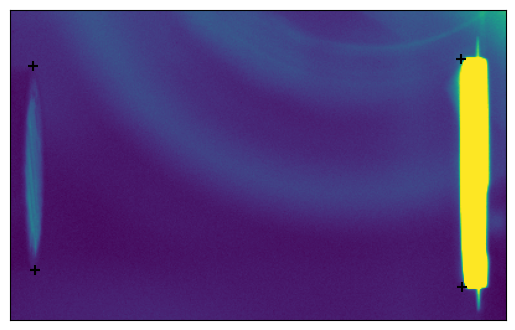

In [3]:
frame_view_YG063 = plume_ds.load_plumes('1-SrRuO3_Pre')[0][0]
coords_YG063 = np.array([[18,45], [20,209], [363,39], [364,223]])
# px.imshow(frame_view_YG063)
visualize_corners(frame_view_YG063, coords_YG063, color='k', marker_size=50)
np.save(f'../../../../datasets/frame_normalization_coords/{ds_name}_coords.npy', coords_YG063)

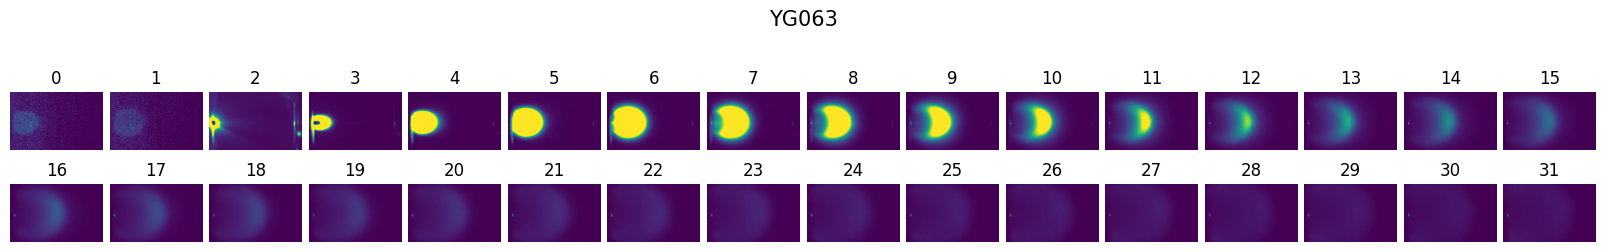

100%|██████████| 380/380 [01:42<00:00,  3.70it/s]


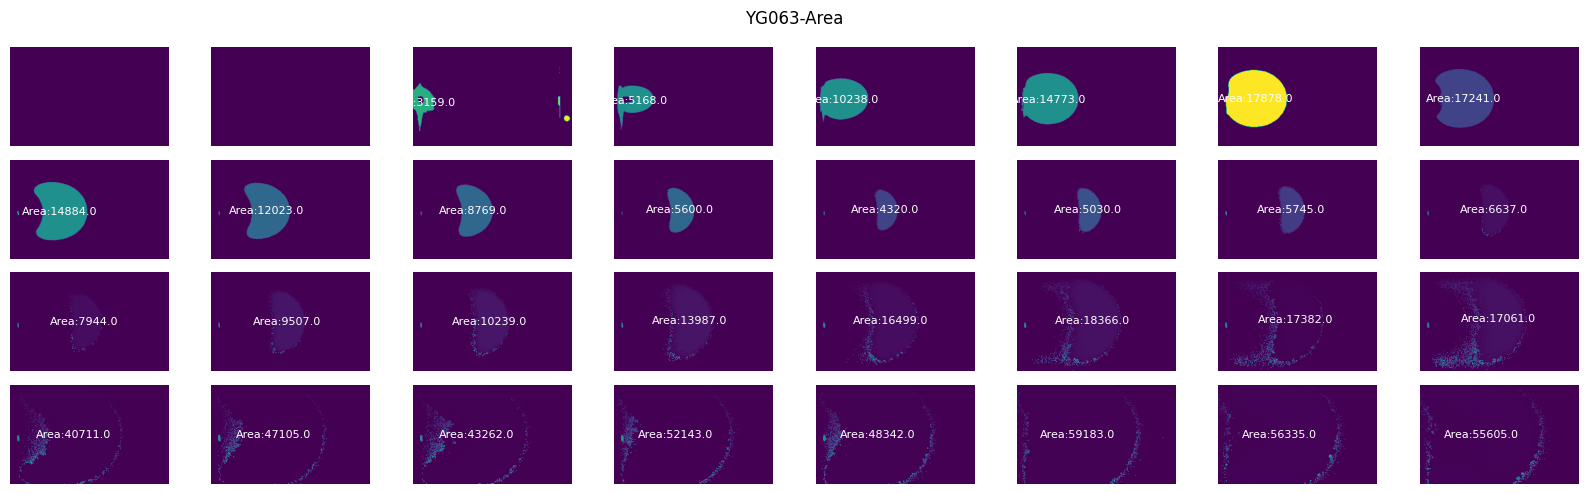

100%|██████████| 380/380 [00:33<00:00, 11.43it/s]


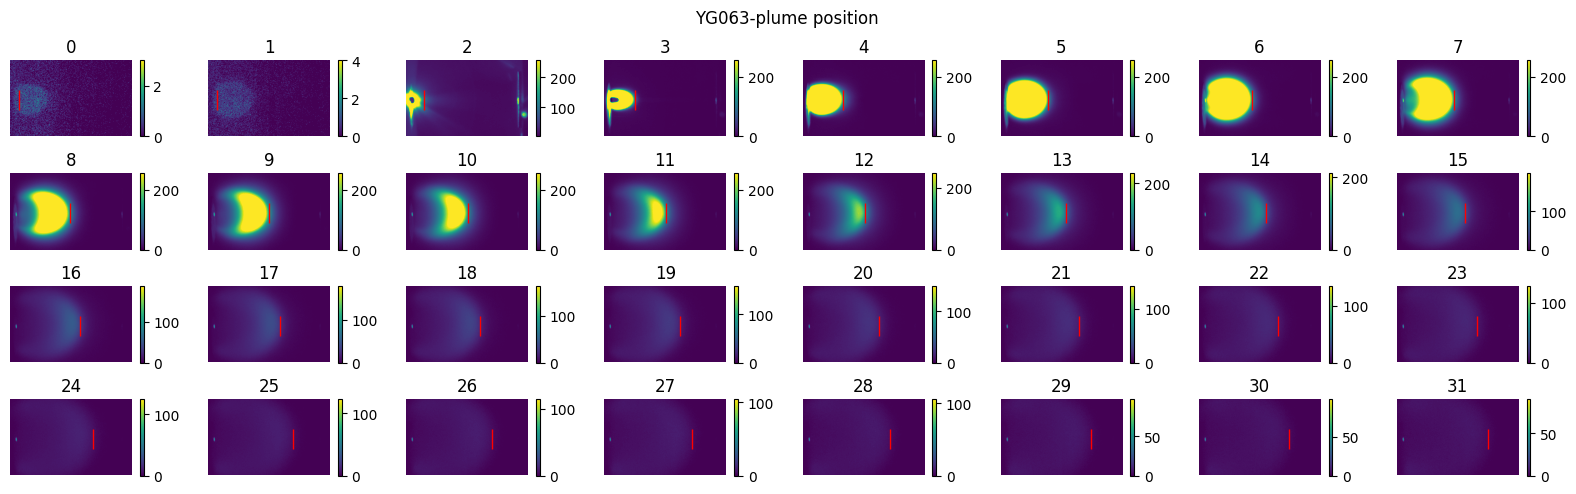

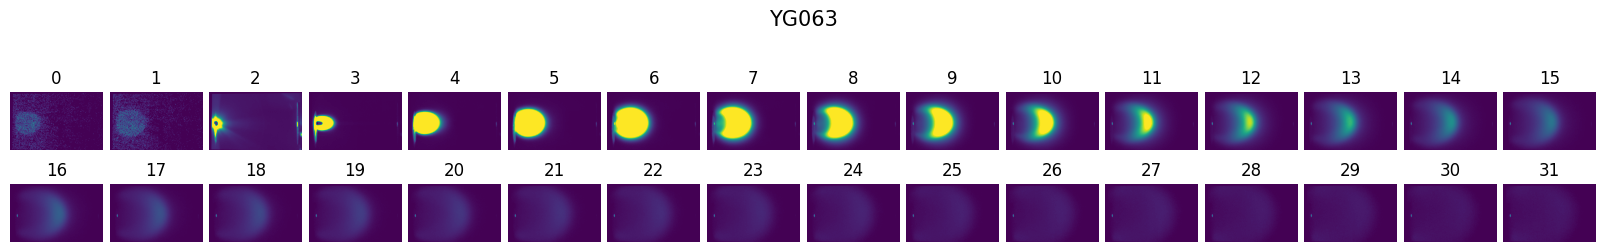

100%|██████████| 380/380 [01:01<00:00,  6.16it/s]


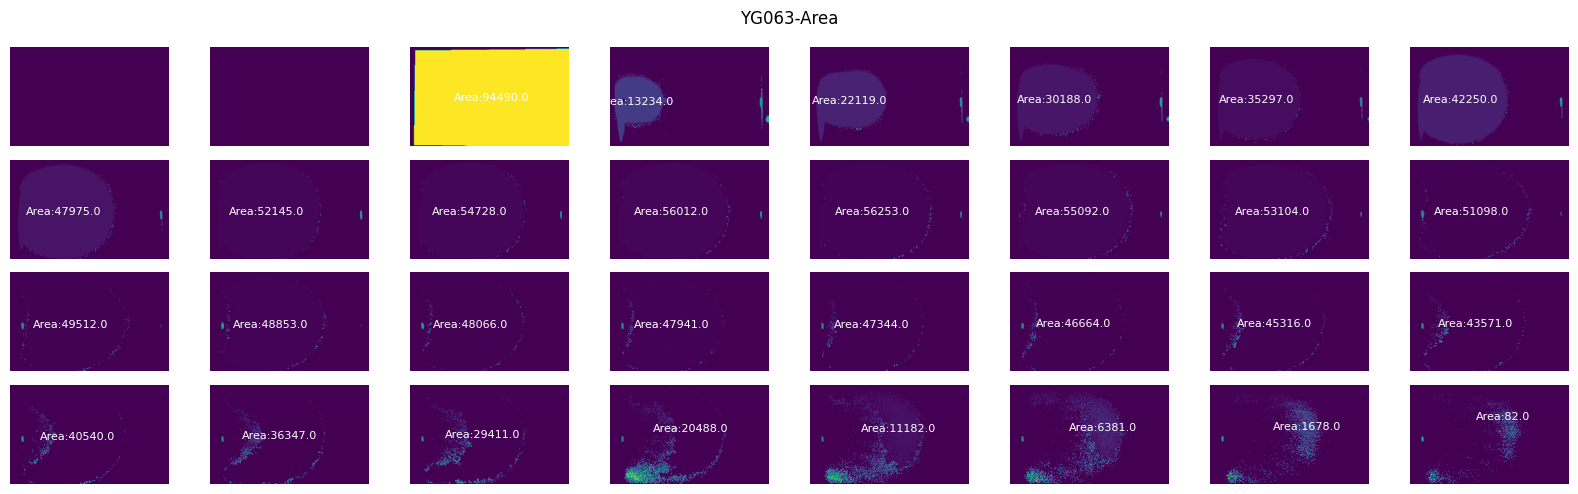

100%|██████████| 380/380 [02:43<00:00,  2.32it/s]


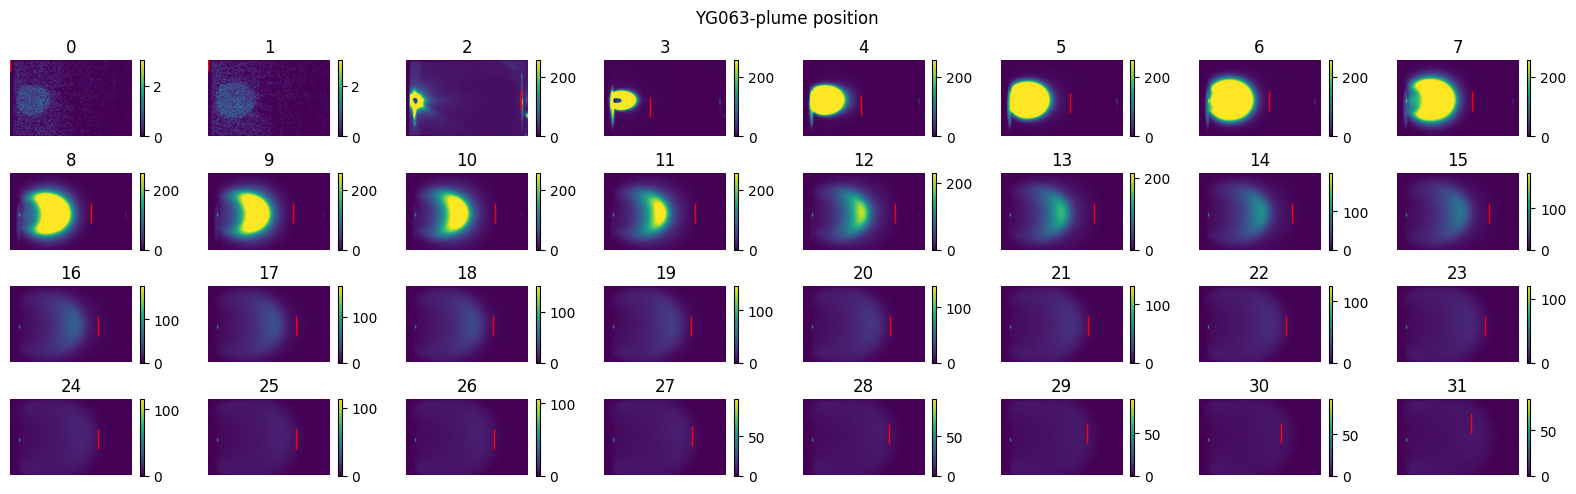

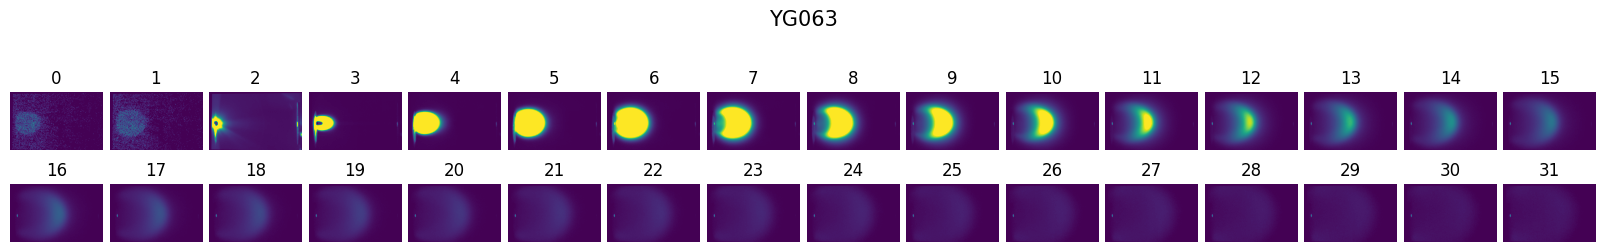

100%|██████████| 380/380 [00:40<00:00,  9.44it/s]


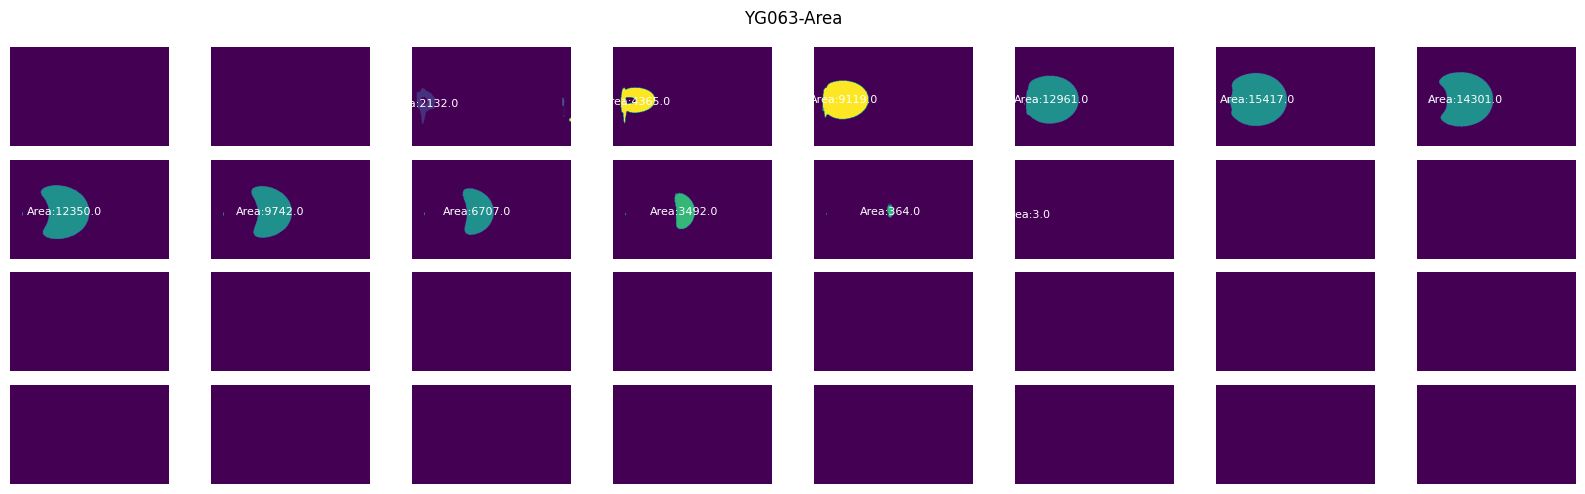

100%|██████████| 380/380 [00:48<00:00,  7.91it/s]


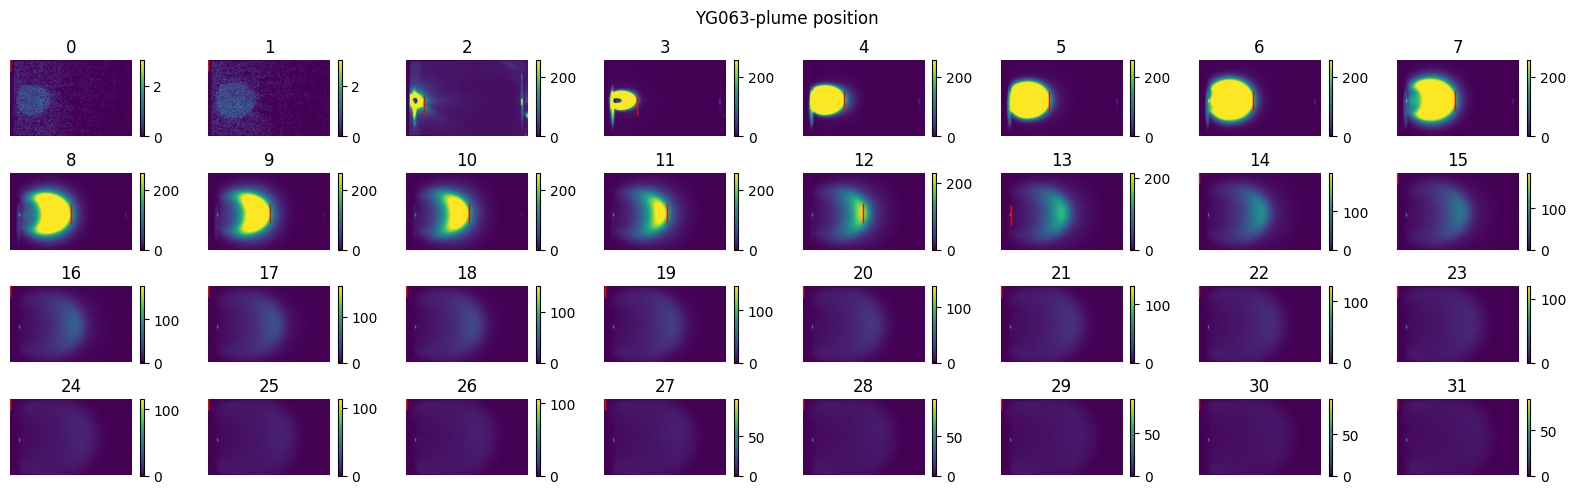

In [4]:
# visualize parameters
viz_parms = {'viz':True, 'index':5, 'viz_index':list(np.arange(0, 32, 1)), 'plume_name': ds_name}

# align parameters
coords_standard = np.load('../../../../datasets/frame_normalization_coords/standard_coords.npy')
align_parms = {'align':False, 'coords':coords_YG063, 'coords_standard':coords_standard}

# metric parameters
start_position = np.round(np.mean(coords_standard[:2], axis=0)).astype(np.int32) # start position of plume  (x, y)
position_range = np.min(coords_standard[:,0]), np.max(coords_standard[:,0]) # x position range

metric_parms = {'time_interval':500e-9, 'start_position':start_position, 'position_range':position_range, 'threshold':'flexible', 'rename_dataset':True}
df_flex = analyze_function(plumes, viz_parms, metric_parms, align_parms={'align':False, 'coords':coords_YG063, 'coords_standard':coords_standard})

metric_parms = {'time_interval':500e-9, 'start_position':start_position, 'position_range':position_range, 'threshold':5, 'rename_dataset':True}
df_5 = analyze_function(plumes, viz_parms, metric_parms, align_parms={'align':True, 'coords':coords_YG063, 'coords_standard':coords_standard})

metric_parms = {'time_interval':500e-9, 'start_position':start_position, 'position_range':position_range, 'threshold':200, 'rename_dataset':True}
df_200 = analyze_function(plumes, viz_parms, metric_parms, align_parms={'align':True, 'coords':coords_YG063, 'coords_standard':coords_standard})

df_all = pd.concat([df_5, df_200, df_flex])
df_all.to_csv('../../../../datasets/SRO_plume_metrics/YG063_metrics.csv')

### plot

In [5]:
df_all = pd.read_csv('../../../../datasets/SRO_plume_metrics/YG063_metrics.csv')
print(df_all['Threshold'].unique())

['5' '200' 'flexible']


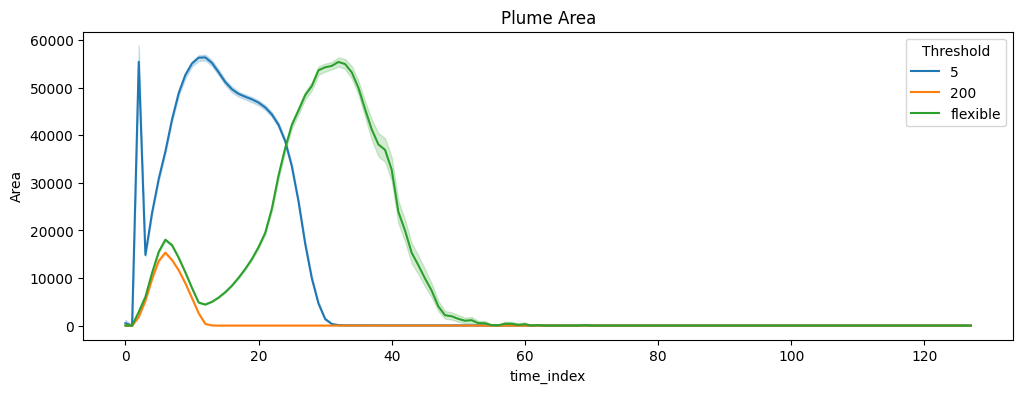

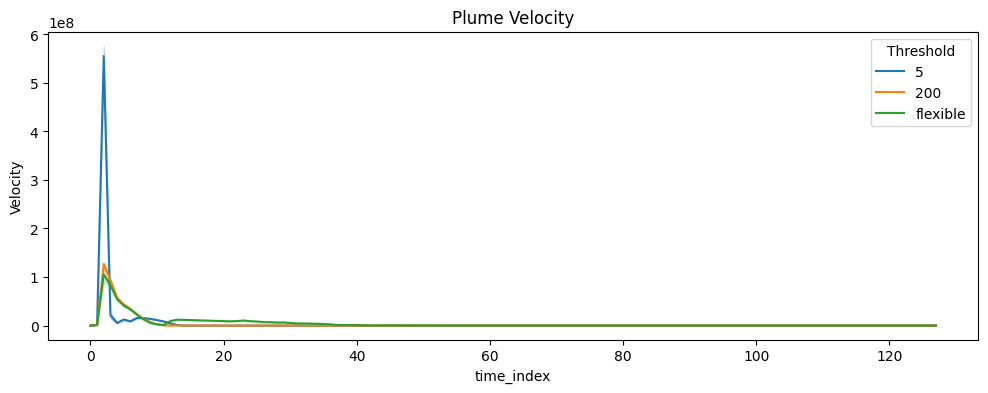

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))
lineplot = sns.lineplot(x="time_index", y="Area", hue="Threshold", data=df_all)
plt.title('Plume Area')
# plt.xlim(0, 32)
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
lineplot = sns.lineplot(x="time_index", y="Velocity", hue="Threshold", data=df_all)
plt.title('Plume Velocity')
plt.show()

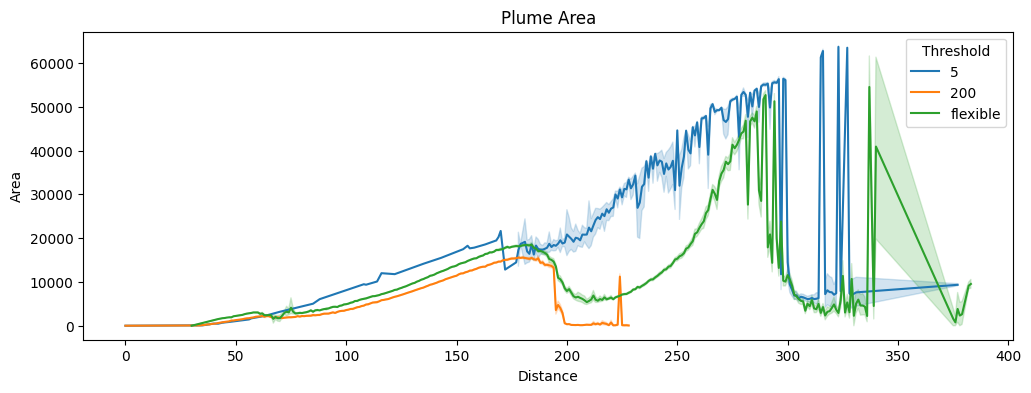

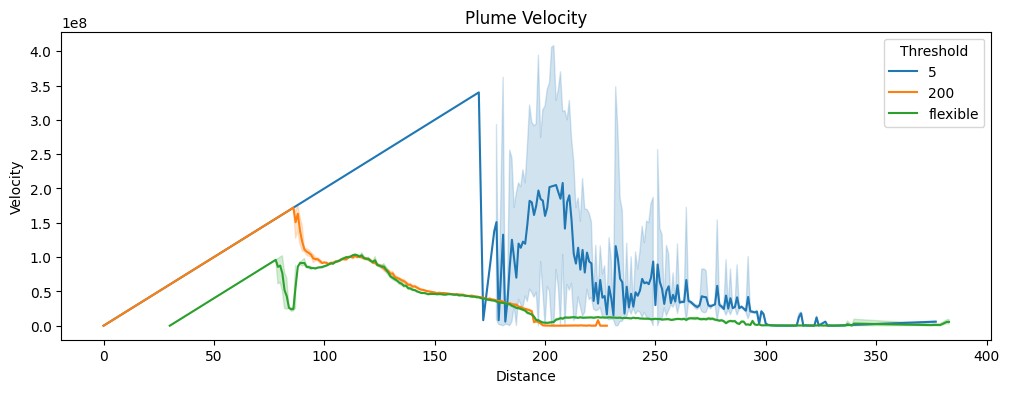

In [7]:
fig, ax = plt.subplots(figsize=(12, 4))
lineplot = sns.lineplot(x="Distance", y="Area", hue="Threshold", data=df_all)
plt.title('Plume Area')
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
lineplot = sns.lineplot(x="Distance", y="Velocity", hue="Threshold", data=df_all)
plt.title('Plume Velocity')
plt.show()